In [1]:
import sys 
import networkx as nx
import pandas as pd
import numpy as np
import pickle as pic
import scipy.stats as stats
import random

import cassiopeia.TreeSolver.simulation_tools.simulation_utils as sim_utils
import cassiopeia.TreeSolver.simulation_tools.Yule_utils as Yule
import cassiopeia.TreeSolver.simulation_tools.dataset_generation as data_gen
from cassiopeia.TreeSolver.Node import Node
from cassiopeia.TreeSolver.Cassiopeia_Tree import Cassiopeia_Tree

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

import subprocess

from Bio import Phylo

#import seaborn as sns
import os

In [2]:
def maxDepth(network, node): #tree height
    if network.out_degree(node) == 0:
        return 1
    else:
        depths = []
        for i in network.successors(node):
            depths.append(maxDepth(network, i))
        return max(depths) + 1
    
def all_depths(network):
    root = [n for n in network if network.in_degree(n) == 0][0]
    depths = all_depths_helper(network, root)
    return depths, sum(depths)/len(depths)
    
def all_depths_helper(network, node):
    if (network.out_degree(node) == 0):
        return [1]
    else:
        depths = []
        for i in network.successors(node):
            depths.extend(all_depths_helper(network, i))
        return [x + 1 for x in depths]
    
def diameter(network): #tree diameter
    root = [n for n in network if network.in_degree(n) == 0][0]
    if (network.out_degree(root) == 0):  
        return 1
    ans = [-1]
    height_of_tree = maxDepth_help(network, root, ans)  
    return ans[0]

def maxDepth_help(network, node, ans): #tree_height helper for tree diameter
    if network.out_degree(node) == 0:
        ans[0] = max(ans[0], 1)
        return 1
    else:
        depths = []
        for i in network.successors(node):
            depths.append(maxDepth_help(network, i, ans))
        ans[0] = max(ans[0], 1 + sum(depths))  
        return max(depths) + 1

def degree_dist(network): #returns dist of out degrees, and average out degree
    out_degrees = []
    for i in network.nodes:
        out_degrees.append(network.out_degree(i))
    fullness = out_degrees.count(1)/len(out_degrees)
    return out_degrees, sum(out_degrees)/len(out_degrees), fullness

def degree_dist_leaves(network): #returns dist of leaf descendants of each node
    root = [n for n in network if network.in_degree(n) == 0][0]
    dist = []
    leaves_dist_helper(network, root, dist)
    return dist, sum(dist)/len(dist)
    
def leaves_dist_helper(network, node, dist):
    if network.out_degree(node) == 0:
        dist.append(0)
        return 1
    else:
        total_leaves = 0
        for i in network.successors(node):
            total_leaves += leaves_dist_helper(network, i, dist)
        dist.append(total_leaves)
        return(total_leaves)
    
def get_character_matrix(nodes):
    
    char_arrays = []
    for n in nodes:
        chars = n.char_string.split("_")[0].split("|")
        char_arrays.append(chars)
        
    return pd.DataFrame(char_arrays)

def states_per_char(network):
    leaves = [n for n in network if network.out_degree(n) == 0]
    cm = get_character_matrix(leaves)
    unique_chars = [0 for n in range(0, cm.shape[1])]
    seen = [[] for n in range(0, cm.shape[1])]
    for j in range(0,cm.shape[1]):
        for i in range(0,cm.shape[0]):
            val = cm.iloc[i, j]
            if val != '0' and val != '-' and val not in seen[j]:
                unique_chars[j] += 1
                seen[j].append(cm.iloc[i, j])
    return unique_chars

def prune_directed_graph(network):
    root = [a for a in network.nodes()][0]
    if network.out_degree(root) > 0:
        for node in network.successors(root):
            directed_graph_helper(network, node, root)
    return
    
def directed_graph_helper(network, node, parent):
    network.remove_edge(node, parent)
    for i in network.successors(node):
            directed_graph_helper(network, i, node)
    return

def balance_dist(network):
    root = [n for n in network if network.in_degree(n) == 0][0]
    height_diffs = []
    max_ = [0]
    balance_dist_helper(network, root, height_diffs, max_)
    return height_diffs, sum(height_diffs)/len(height_diffs), max_[0]

def balance_dist_helper(network, node, ans, max_): #tree height helper for distribution of height differences
    if network.out_degree(node) == 0:
        return 1
    else:
        depths = []
        for i in network.successors(node):
            depths.append(balance_dist_helper(network, i, ans, max_))
        if len(depths) > 1:
            ans.append(max(depths) - min(depths))
            max_[0] = max(max_[0], max(depths) - min(depths))
        return max(depths) + 1
    
def get_KL_from_vectors(vec1, vec2):

    all_dist = []
    all_dist.extend(vec1)
    all_dist.extend(vec2)
    hist1 = [0] * (max(all_dist) - min(all_dist) + 1)
    hist2 = [0] * (max(all_dist) - min(all_dist) + 1)
    for i in vec1:
        hist1[i - min(all_dist)] += 1
    for i in vec2:
        hist2[i - min(all_dist)] += 1
    dist1 = [x/sum(hist1) for x in hist1]
    dist2 = [x/sum(hist2) for x in hist2]

    return s_d.jensenshannon(dist1, dist2)

def frange(start, stop, step):
    res, n = start, 1

    while res < stop:
        yield res
        res = start + n * step
        n += 1

In [3]:
def get_character_matrix(nodes):
    
    char_arrays = []
    for n in nodes:
        chars = n.char_string.split("_")[0].split("|")
        char_arrays.append(chars)
        
    return pd.DataFrame(char_arrays)

def compute_priors(C, S, p, mean=0.01, disp=0.1, skew_factor = 0.05, num_skew=1, empirical = np.array([]), mixture = 0):
    
    sp = {}
    prior_probabilities = {}
    for i in range(0, C):
        if len(empirical) > 0:
            sampled_probabilities = sorted(empirical)
        else:
            sampled_probabilities = sorted([np.random.negative_binomial(mean,disp) for _ in range(1,S+1)])
        s = C % num_skew
        mut_rate = p * (1 + num_skew * skew_factor)
        prior_probabilities[i] = {'0': (1-mut_rate)}
        total = np.sum(sampled_probabilities)

        sampled_probabilities = list(map(lambda x: x / (1.0 * total), sampled_probabilities))
        
        if mixture > 0: 
            for s in range(len(sampled_probabilities)):
                if np.random.uniform() <= mixture:
                    sampled_probabilities[s] = np.random.uniform()
            
            sp[i] = sampled_probabilities 
            total = np.sum(sampled_probabilities)
            sampled_probabilities = list(map(lambda x: x / (1.0 * total), sampled_probabilities))
            
            
        for j in range(1, S+1):
            prior_probabilities[i][str(j)] = (mut_rate)*sampled_probabilities[j-1]

    return prior_probabilities, sp

def count_all_dropouts_leaves(leaves):
    count = 0
    for node in leaves:
        sample = node.get_character_string().split('|')
        for i in sample:
            if (i == '-' or i == '*'):
                count += 1
    return count

In [4]:
def overlay_mutation(network, mutation_prob_map, basal_rate, cassette_size):
    root = [n for n in network if network.in_degree(n) == 0][0]
    mutation_cache = {}
    
    for i in mutation_prob_map: #edit the mutation map to only include the probs 
                                #of mutating to each state, given that character is chosen to mutate
        sum = 0
        mutation_prob_map[i].pop('0', None)
        for j in mutation_prob_map[i]:
            sum += mutation_prob_map[i][j]
        new_probs = {}
        for j in mutation_prob_map[i]:
            new_probs[j] = mutation_prob_map[i][j]/sum
        mutation_prob_map[i] = new_probs
    
    mutation_prob_map['basal_mut_rate'] = basal_rate
    
    mutation_helper(network, root, mutation_prob_map, mutation_cache, root.char_vec, [], cassette_size)

def mutation_helper(network, node, mutation_prob_map, mutation_cache, curr_mutations, dropout_indices, cassette_size):
    new_sample = curr_mutations.copy()
    new_dropout_indices = dropout_indices.copy()
    t = network.nodes[node]['lifespan']
    if t == 0:
        node.char_vec = new_sample
        node.char_string = '|'.join([str(char) for char in new_sample])
        network.nodes[node]['dropout'] = new_dropout_indices
        return
    mut_rate = mutation_prob_map['basal_mut_rate']
    p = 0
    
    if len(mutation_cache) == 0:
        mutation_cache[1] = mut_rate
    
    if t in mutation_cache:
        p = mutation_cache[t]
    else:
        t_p = max(mutation_cache.keys())
        p = mutation_cache[t_p]
        for t_temp in range(t_p + 1, t + 1):
            p += mut_rate * (1 - mut_rate) ** (t_temp - 1)
            mutation_cache[t_temp] = p
            
    base_chars = []
    for i in range(0, len(new_sample)):
        if new_sample[i] == '0' and i not in new_dropout_indices:
            base_chars.append(i)
    
    times = {}
    draws = np.random.binomial(len(base_chars), p)
    chosen_ind = np.random.choice(base_chars, draws)
    for i in chosen_ind:
        values, probabilities = zip(*mutation_prob_map[i].items())
        new_character = np.random.choice(values, p=probabilities)
        new_sample[i] = new_character
        time = np.random.choice(range(1, t + 1))
        for ti in range(time - 2, time + 3):
            if ti >= 1 and ti <= t:
                if ti in times:
                    times[ti].append(i)
                else:
                    times[ti] = [i]
    
    for time in sorted(times.keys()):
        if len(times[time]) > 1:
            not_dropped = []
            for i in times[time]:
                if i not in new_dropout_indices:
                    not_dropped.append(i)
            for c in range(0, (len(new_sample)//cassette_size)):
                cass_indices = []
                for i in not_dropped:
                    if (i >= c * cassette_size and i < (c + 1) * cassette_size):
                        cass_indices.append(i)
                if len(cass_indices) > 1:
                    for e in range(min(cass_indices), max(cass_indices) + 1):
                        new_dropout_indices.append(e)
             
    node.char_vec = new_sample
    node.char_string = '|'.join([str(char) for char in new_sample])
    network.nodes[node]['dropout'] = new_dropout_indices

    if network.out_degree(node) > 0:
        for i in network.successors(node):
            mutation_helper(network, i, mutation_prob_map, mutation_cache, new_sample, new_dropout_indices, cassette_size)

def overlay_heritable_dropout(network):
    root = [n for n in network if network.in_degree(n) == 0][0]
    h_dropout_helper(network, root)

def h_dropout_helper(network, node):
    new_sample = node.char_vec.copy()
    for i in network.nodes[node]['dropout']:
        new_sample[i] = '-'
    node.char_vec = new_sample
    node.char_string = '|'.join([str(char) for char in new_sample])

    if network.out_degree(node) > 0:
        for i in network.successors(node):
            h_dropout_helper(network, i)
            
def add_stochastic_leaves(leaves, dropout_prob, cassette_size):
    for node in leaves:
        sample = node.char_vec.copy()
        for i in range(0, len(sample)//cassette_size):
            if random.uniform(0, 1) <= dropout_prob:
                for j in range(i * cassette_size, (i + 1) * cassette_size):
                    sample[j] = '-'
        node.char_vec = sample
        node.char_string = '|'.join([str(char) for char in sample])


In [147]:
def phylo_forward_pass(
    timesteps, 
    min_division_rate,
    #U = lambda: np.random.exponential(1, 1),
    fitness_rate,
    epsilon,
    cell_death,
    cassette_size = 3,
    cassette_number = 10
):
    
    characters = cassette_size * cassette_number
    
#     division_rate = min_division_rate + np.random.exponential(1, 1) * (1 - min_division_rate) # probability that cell will double per time-step
    division_rate = min_division_rate
    
    network = nx.DiGraph()
    current_cells = [[['0' for _ in range(0, characters)], '0']]
    
    network.add_node(sim_utils.node_to_string(current_cells[0]))
    network.nodes[sim_utils.node_to_string(current_cells[0])]['fitness'] = division_rate
    network.nodes[sim_utils.node_to_string(current_cells[0])]['lifespan'] = 0
    uniq = 1
    
    for t in range(0, timesteps + 1):
        temp_current_cells = []
#         if len(current_cells) == 0:
#             print("all cells dead, terminating")
#             break
#         current_fitnesses = [network.nodes[sim_utils.node_to_string(n)]['fitness'] for n in current_cells]
#         norm = np.max(current_fitnesses)
        
        for node in current_cells:
            fitness = network.nodes[sim_utils.node_to_string(node)]['fitness']
            network.nodes[sim_utils.node_to_string(node)]['lifespan'] += 1
            
            if np.random.random() >= cell_death:
                
                if np.random.random() <= fitness_rate: #cell gains a fitness mutation
#                     if t == (timesteps - 1):
#                         network.node[node]['fitness'] = fitness
#                     else:
#                     s = max(1e-20, U()[0])
                    if np.random.random() <= 0.5:
                        fitness = fitness + epsilon
                    else:
                        fitness = fitness - epsilon
                    network.nodes[sim_utils.node_to_string(node)]['fitness'] = fitness
                
                if np.random.random() <= fitness: #and t != (timesteps - 1): #cell divides
                    for _ in range(0,2):
                        temp_current_cells.append([node[0], str(uniq)])
                        network.add_edge(sim_utils.node_to_string(node), sim_utils.node_to_string([node[0], str(uniq)]))
                        network.nodes[sim_utils.node_to_string([node[0], str(uniq)])]['fitness'] = fitness
                        network.nodes[sim_utils.node_to_string([node[0], str(uniq)])]['lifespan'] = 0
                        uniq += 1
                else: #cell does not divide
                    temp_current_cells.append(node)
                                    
            else: #if cell dies
                curr_parent = sim_utils.node_to_string(node)
                while network.out_degree(curr_parent) < 1 and network.in_degree(curr_parent) > 0:
                    next_parent = list(network.predecessors(curr_parent))[0]
                    network.remove_node(curr_parent)
                    curr_parent = next_parent
                
        current_cells = temp_current_cells
#         print("timestep:" + str(t))
#         print("size:" + str(len(current_cells)))
        
    rdict = {}
    i = 0
    for n in network.nodes:
        nn = Node("StateNode" + str(i), n.split("_")[0].split("|"), pid = n.split("_")[1], is_target=False)
        i += 1
        rdict[n] = nn

    network = nx.relabel_nodes(network, rdict)
    
#     source = [x for x in network.nodes() if network.in_degree(x)==0][0]

#     max_depth = max(nx.shortest_path_length(network,source,node) for node in network.nodes())
#     shortest_paths = nx.shortest_path_length(network,source)

#     leaves = [x for x in network.nodes() if network.out_degree(x)==0 and network.in_degree(x) == 1 and shortest_paths[x] == max_depth]

    leaves2 = [n for n in network if network.out_degree(n) == 0 and network.in_degree(n) == 1] 
    
    state_tree = Cassiopeia_Tree('simulated', network = network)
    return state_tree, leaves2

In [148]:
path = "/data/yosef2/users/richardz/projects/Yule/Chow_trees"

size_c = []
max_heights_c = []
avg_heights_c = []
widths_c = []
avg_deg_c = []
avg_leaf_deg_c = []
balances_c = []

for i in range(1, 106):
    tree = Phylo.read(path + "/ground_" + str(i) + ".nwk", 'newick')
    network = Phylo.to_networkx(tree)
    network = network.to_directed()
    prune_directed_graph(network)
    
    root = [a for a in network.nodes()][0]
    leaves = [n for n in network if network.out_degree(n) == 0]
    if len(leaves) == 0:
        continue
    size_c.append(len(leaves))
    max_heights_c.append(maxDepth(network, root))
    avg_heights_c.append(all_depths(network)[1])
    widths_c.append(diameter(network))
    avg_deg_c.append(degree_dist(network)[1])
    avg_leaf_deg_c.append(degree_dist_leaves(network)[1])
    balances_c.append(balance_dist(network)[1])

In [194]:
timesteps = 10000
division_rate = 0.00026253
#U = lambda: np.random.exponential(1, 1),
fitness_rate = 0.000
epsilon = 0.001
cell_death = 0.000

        
# for division_rate in frange(0.004, 0.005, 0.0001):
# #     for cell_death in frange(0, 0.00305, 0.0001):

size = []
#         max_heights = []
avg_heights = []
#         widths = []
# avg_deg = []
# avg_leaf_deg = []
# avg_unique_chars = []
balances = []
for i in range(1, 106):
    out, leaves = phylo_forward_pass(timesteps = timesteps, 
                                          min_division_rate = division_rate, 
                                          fitness_rate = fitness_rate, 
                                          epsilon = epsilon, 
                                          cell_death = cell_death)
    while len(leaves) == 0:
        out, leaves = phylo_forward_pass(timesteps = timesteps, 
                                              min_division_rate = division_rate, 
                                              fitness_rate = fitness_rate, 
                                              epsilon = epsilon,
                                              cell_death = cell_death)

    network = out.network
    num_leaves = len(leaves)
    size.append(num_leaves)

    root = [n for n in network if network.in_degree(n) == 0][0]
#             max_heights.append(maxDepth(network, root))
    avg_heights.append(all_depths(network)[1])
#             widths.append(diameter(network))

#     avg_deg.append(degree_dist(network)[1])
#     avg_leaf_deg.append(degree_dist_leaves(network)[1])
    balances.append(balance_dist(network)[1])

#         print(size)
#         print(stats.ks_2samp(size, size_c)[1])
if stats.ks_2samp(size, size_c)[1] > .00001:
    print(division_rate, cell_death)
    print("size")
    print("stat: " + str(stats.ks_2samp(size, size_c)[0]), "p-value: " + str(stats.ks_2samp(size, size_c)[1]))
    print("avg_height")
    print("stat: " + str(stats.ks_2samp(avg_heights, avg_heights_c)[0]), "p-value: " + str(stats.ks_2samp(avg_heights, avg_heights_c)[1]))



0.00026253 0.0
size
stat: 0.18095238095238095 p-value: 0.06409463149747963
avg_height
stat: 0.24761904761904763 p-value: 0.0030860143013870006


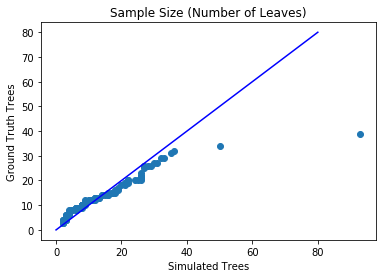

In [195]:
plt.scatter(sorted(size), sorted(size_c))
# plt.plot(range(min(size),max(size) + 1), range(min(size),max(size) + 1), 'b')
plt.plot([0, 80], [0, 80], 'b')
plt.title("Sample Size (Number of Leaves)")
plt.xlabel("Simulated Trees")
plt.ylabel("Ground Truth Trees")
plt.show()

In [196]:
import statistics as stat
print("mean " + str(stat.mean(size)) )
print("SD " + str((stat.variance(size)) ** (1/2)))


mean 14.380952380952381
SD 12.433191427958032


In [87]:
# path = "/data/yosef2/users/richardz/projects/Yule/topology/t7"

# size = []
# max_heights = []
# avg_heights = []
# widths = []
# avg_deg = []
# avg_leaf_deg = []
# balances = []

# for i in range(1, 105):
#     net = pic.load(open(path + "/dropout_net" + str(i) + ".pkl", 'rb'))
#     network = net.network
    
#     root = [a for a in network.nodes()][0]
#     leaves = [n for n in network if network.out_degree(n) == 0 and network.in_degree(n) == 1]
#     size.append(len(leaves))
#     max_heights.append(maxDepth(network, root))
#     avg_heights.append(all_depths(network)[1])
#     widths.append(diameter(network))
#     avg_deg.append(degree_dist(network)[1])
#     avg_leaf_deg.append(degree_dist_leaves(network)[1])
#     balances.append(balance_dist(network)[2])


In [ ]:
# path = "/data/yosef2/users/richardz/projects/Yule/topology/t7"
# if os.path.exists(path) == False:
#     os.mkdir(path)  

# timesteps = 7
# division_rate = 0.55
# #U = lambda: np.random.exponential(1, 1),
# fitness_rate = 0.000
# epsilon = 0.001
# cell_death = 0.000    
    
# # counts = []
# size = []
# max_heights = []
# avg_heights = []
# widths = []
# avg_deg = []
# avg_leaf_deg = []
# for i in range(1, 106):
#     out, leaves = Yule.phylo_forward_pass(timesteps = timesteps, 
#                                           min_division_rate = division_rate, 
#                                           fitness_rate = fitness_rate, 
#                                           epsilon = epsilon, 
#                                           cell_death = cell_death)
#     while len(leaves) == 0:
#         out, leaves = Yule.phylo_forward_pass(timesteps = timesteps, 
#                                       min_division_rate = division_rate, 
#                                       fitness_rate = fitness_rate, 
#                                       epsilon = epsilon, 
#                                       cell_death = cell_death)
    
    
#     network = out.network
#     pic.dump(out, open(path + '/dropout_net' + str(i) + '.pkl', 'wb'))
    
#     root = [a for a in network.nodes()][0]
#     size.append(len(leaves))
#     max_heights.append(maxDepth(network, root))
#     avg_heights.append(all_depths(network)[1])
#     widths.append(adiameter(network))
#     avg_deg.append(degree_dist(network)[1])
#     avg_leaf_deg.append(degree_dist_leaves(network)[1])

In [ ]:
plt.scatter(sorted(size), sorted(size_c))
plt.plot(range(min(size),max(size) + 1), range(min(size),max(size) + 1), 'b')
# plt.plot([0, 30], [0, 30], 'b')
plt.title("Sample Size (Number of Leaves)")
plt.xlabel("Simulated Trees")
plt.ylabel("Ground Truth Trees")
plt.show()

In [ ]:
plt.scatter(sorted(max_heights), sorted(max_heights_c))
plt.plot(range(min(max_heights),max(max_heights) + 1), range(min(max_heights),max(max_heights) + 1), 'b')
plt.title("Maximum Height of Trees")
plt.xlabel("Simulated Trees")
plt.ylabel("Ground Truth Trees")
plt.show()

In [ ]:
plt.scatter(sorted(avg_heights), sorted(avg_heights_c))
plt.plot([min(avg_heights),max(avg_heights)], [min(avg_heights),max(avg_heights)], 'b')
plt.title("Average Height of Trees")
plt.xlabel("Simulated Trees")
plt.ylabel("Ground Truth Trees")
plt.show()

In [ ]:
plt.scatter(sorted(widths), sorted(widths_c))
plt.plot(range(min(widths),max(widths) + 1), range(min(widths),max(widths) + 1), 'b')
plt.title("Diameter of Trees")
plt.xlabel("Simulated Trees")
plt.ylabel("Ground Truth Trees")
plt.show()

In [ ]:
plt.scatter(sorted(avg_deg), sorted(avg_deg_c))
plt.plot([0.9,1], [0.9,1], 'b')
plt.title("Average Outdegree of Nodes")
plt.xlabel("Simulated Trees")
plt.ylabel("Ground Truth Trees")
plt.show()

In [ ]:
plt.scatter(sorted(balances), sorted(balances_c))
# plt.plot(range(min(balances),max(balances) + 1), range(min(balances),max(balances) + 1), 'b')
plt.plot([0,8], [0,8], 'b')
plt.title("Maximum Difference of Height of Subtrees Across Nodes with 2 Branches")
plt.xlabel("Simulated Trees")
plt.ylabel("Ground Truth Trees")
plt.show()

In [ ]:
tree = Phylo.read('/data/yosef2/users/richardz/projects/DreamChallenge/subC1/sub1_train_' + str(6) + '.nwk', 'newick')
network = Phylo.to_networkx(tree)
network = network.to_directed()
prune_directed_graph(network)

root = [a for a in network.nodes()][0]
maxDepth(network, root)

nx.draw(network)

In [ ]:
net = pic.load(open(path + "/dropout_net" + str(4) + ".pkl", 'rb'))
network = net.network

nx.draw(network)

In [206]:
path = "/data/yosef2/users/richardz/projects/Yule/benchmarking/t500"

size = []
max_heights = []
avg_heights = []
widths = []
avg_deg = []
avg_leaf_deg = []
balances = []

for i in range(1, 51):
    net = pic.load(open(path + "/dropout_net" + str(i) + ".pkl", 'rb'))
    network = net.network
    
    root = [a for a in network.nodes()][0]
    leaves = [n for n in network if network.out_degree(n) == 0 and network.in_degree(n) == 1]
    size.append(len(leaves))
    max_heights.append(maxDepth(network, root))
    avg_heights.append(all_depths(network)[1])
    widths.append(diameter(network))
    avg_deg.append(degree_dist(network)[1])
    avg_leaf_deg.append(degree_dist_leaves(network)[1])
    balances.append(balance_dist(network)[1])

In [207]:
path = "/data/yosef2/users/richardz/projects/Yule/benchmarking/old_sim"

size2 = []
max_heights2 = []
avg_heights2 = []
widths2 = []
avg_deg2 = []
avg_leaf_deg2 = []
balances2 = []

for i in range(0, 50):
    net = pic.load(open(path + "/dropout_net" + str(i) + ".pkl", 'rb'))
    network = net.network
    
    root = [a for a in network.nodes()][0]
    leaves = [n for n in network if network.out_degree(n) == 0 and network.in_degree(n) == 1]
    size2.append(len(leaves))
    max_heights2.append(maxDepth(network, root))
    avg_heights2.append(all_depths(network)[1])
    widths2.append(diameter(network))
    avg_deg2.append(degree_dist(network)[1])
    avg_leaf_deg2.append(degree_dist_leaves(network)[1])
    balances2.append(balance_dist(network)[1])

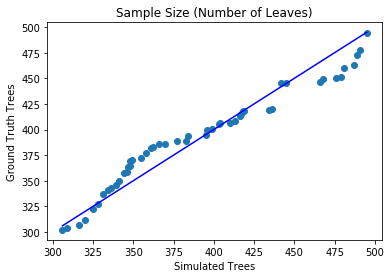

In [211]:
plt.scatter(sorted(size), sorted(size2))
plt.plot(range(min(size),max(size) + 1), range(min(size),max(size) + 1), 'b')
# plt.plot([0, 30], [0, 30], 'b')
plt.title("Sample Size (Number of Leaves)")
plt.xlabel("Simulated Trees")
plt.ylabel("Ground Truth Trees")
plt.show()

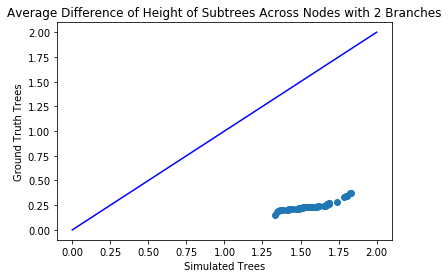

In [210]:
plt.scatter(sorted(balances), sorted(balances2))
# plt.plot(range(min(balances),max(balances) + 1), range(min(balances),max(balances) + 1), 'b')
plt.plot([0,2], [0,2], 'b')
plt.title("Average Difference of Height of Subtrees Across Nodes with 2 Branches")
plt.xlabel("Simulated Trees")
plt.ylabel("Ground Truth Trees")
plt.show()

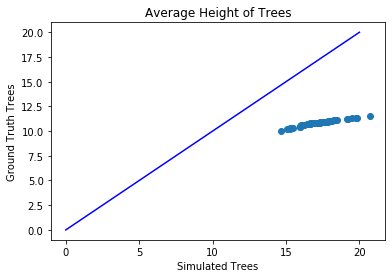

In [213]:
plt.scatter(sorted(avg_heights), sorted(avg_heights2))
# plt.plot([min(avg_heights),max(avg_heights)], [min(avg_heights),max(avg_heights)], 'b')
plt.plot([0,20], [0,20], 'b')
plt.title("Average Height of Trees")
plt.xlabel("Simulated Trees")
plt.ylabel("Ground Truth Trees")
plt.show()

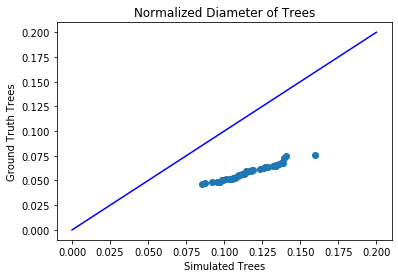

In [219]:
norm_widths = [widths[i]/size[i] for i in range(0, len(widths))]
norm_widths2 = [widths2[i]/size2[i] for i in range(0, len(widths2))]
plt.scatter(sorted(norm_widths), sorted(norm_widths2))
plt.plot([0,0.2], [0,0.2], 'b')
# plt.plot(range(min(widths),max(widths) + 1), range(min(widths),max(widths) + 1), 'b')
plt.title("Normalized Diameter of Trees")
plt.xlabel("Simulated Trees")
plt.ylabel("Ground Truth Trees")
plt.show()

In [ ]:
print("size")
print("stat: " + str(stats.ks_2samp(size, size_c)[0]), "p-value: " + str(stats.ks_2samp(size, size_c)[1]))

print("avg_heights")
print("stat: " + str(stats.ks_2samp(avg_heights, avg_heights_c)[0]), "p-value: " + str(stats.ks_2samp(avg_heights, avg_heights_c)[1]))


In [131]:
import statistics as stat
(stat.variance(size_c)) ** (1/2)
# stat.mean(size_c)

7.59439980675948

In [295]:
from dendropy.simulate import treesim

birth_rate=0.26253
death_rate=0
max_time=10

size = []
#         max_heights = []
avg_heights = []
#         widths = []
# avg_deg = []
# avg_leaf_deg = []
# avg_unique_chars = []
# balances = []
for i in range(1, 106):

    t = treesim.birth_death_tree(birth_rate=birth_rate, death_rate=death_rate, max_time=max_time)
    num_leaves = 0
    for node in t.leaf_node_iter():
        num_leaves += 1
    size.append(num_leaves)

if stats.ks_2samp(size, size_c)[1] > .00001:
    print(birth_rate, death_rate)
    print("size")
    print("stat: " + str(stats.ks_2samp(size, size_c)[0]), "p-value: " + str(stats.ks_2samp(size, size_c)[1]))
#     print("avg_height")
#     print("stat: " + str(stats.ks_2samp(avg_heights, avg_heights_c)[0]), "p-value: " + str(stats.ks_2samp(avg_heights, avg_heights_c)[1]))



0.26253 0
size
stat: 0.2857142857142857 p-value: 0.00035039653867457223


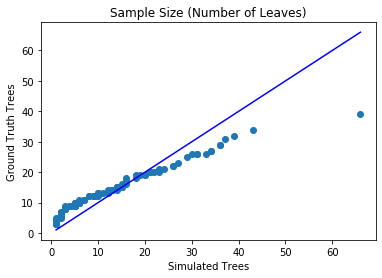

In [296]:
plt.scatter(sorted(size), sorted(size_c))
plt.plot(range(min(size),max(size) + 1), range(min(size),max(size) + 1), 'b')
# plt.plot([0, 30], [0, 30], 'b')
plt.title("Sample Size (Number of Leaves)")
plt.xlabel("Simulated Trees")
plt.ylabel("Ground Truth Trees")
plt.show()

In [297]:
print("mean " + str(stat.mean(size)) )
print("SD " + str((stat.variance(size)) ** (1/2)))

mean 12.638095238095238
SD 11.807855769590763


In [307]:
t = treesim.birth_death_tree(birth_rate=1, death_rate=0, num_extant_tips = 4)

In [311]:
for i in t.edges():
    print(i.length)

1.380862380806234
0.22558014617335156
0
0
0.20695403305189125
0.018626113121460303
0.018626113121460303


In [ ]:
t.plot()